# Emotion Classification from Faces with CNN & PyTorch - Part 3 - Processing

In this series we will continue builind a model that will guess the emotion of a person from a facial expression. We will add techniques such as batch normalization and hyperparameters tuning, and add layers to make more advance models compared to part one.

The model will be trained only with the seven basic emtotions identified by Ekman: anger, disgust, contempt, happiness, sadness, fear, surprise.

Moreover, the model will look only at photos of real people (no cartoon or generated images), to capture microexpressions, which are crucual to give high accuracy to such a model. In fact, humans heavily rely on microexpressions to distinguish between different emotions in the arc of milliseconds (e.g., fear from surprise, disgust from contempt), and taking those out of the equations would mean removing key elememnts. A challenge might be increasing the quality of the images used for training, then burdening the computational power with an heavier dataset. Feature engineering might be key in selecting the parts of the images that are the most relevant, eliminating everything else.

Finally we will build different Convolutional Neural Networks and evaluate the different models. Since the whole process will take a significant amount of code, the work will be divided into different notebooks linking to each other.

The first notebook focused in loading, cleaning, and augmenting the data. Whereas the first part of the modelling testes different combinations of models and make observations.
- [Emotion Recognition from Faces with CNN - Exploratory Data Analysis (EDA)](https://www.kaggle.com/code/gabrielenoaro/emotion-recognition-from-faces-with-cnn-eda)
- [Emotion_Classification_from_Faces_with_CNN_Part_1](https://www.kaggle.com/code/gabrielenoaro/emotion-recognition-from-faces-with-cnn-pytorch-1)
- [Emotion_Classification_from_Faces_with_CNN_Part_2](https://www.kaggle.com/code/gabrielenoaro/emotion-classification-from-faces-with-cnn-part-2)

You can find the part relative to data preprocessing here:
- [Emotion Classification from Faces CNN 3 Models](https://www.kaggle.com/code/gabrielenoaro/emotion-classification-from-faces-cnn-3-models)

Since we have already loaded, cleaned, and inspected the data in our previous notebook [Emotion Recognition from Faces with CNN - Exploratory Data Analysis (EDA)](https://www.kaggle.com/code/gabrielenoaro/emotion-recognition-from-faces-with-cnn-eda), we will jump directly to data preprocessing.

In this notebook we want to to eliminate heavily underrepresented classes, perform random data reduction on overepresented classes, and do some data augmentation on the training set.

This will help us solve the data leakage and overfitting issues we encountered in  ([Emotion_Classification_from_Faces_with_CNN_Part_2](https://www.kaggle.com/code/gabrielenoaro/emotion-classification-from-faces-with-cnn-part-2)).

## Table of contents

1. [Load the libraries](#load-the-data)
2. [Helper functions for data processing](#helper-functions-for-data-proccessing)
3. [Exploratory Data Analysis](#exploratory-data-analysis)
4. [Data preprocessing, splitting, and augmentation](#data-preprocessing-splitting-and-augmentation)

3. [Split the data](#split-the-data)
4. [Build the models](#build-the-models)    
5. [Train and test the models](#train-and-test-the-models)

    5.1 [Define the hyperparameters](#define-the-hyperparameters)

    5.2 [Helper functions for training, testing, and plotting](#helper-functions-for-training-testing-and-plotting)
    
    5.3 [Train the models](#train-the-models)
    
    5.4 [Test the models](#test-the-models)

    5.5 [Table with the results of the different models](#table-with-the-results-of-the-different-models)

    5.6 [Confusion matrix of the best model](#confusion-matrix-of-the-best-model)

6. [Conclusions](#conclusions)

    6.1 [Observations](#observations)

    6.2 [Lessons learned](#lessons-learned)

    6.3 [Limitations with the data](#limitations-with-the-data)

    6.4 [Next steps](#next-steps)

## Load the libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pickle
import random
from hashlib import md5
import matplotlib.pyplot as plt
import copy

from scipy.stats import uniform
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler

import os,cv2
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchsummary import summary


We want also to set a random seed to maintain consistency across our experiments.

In [2]:
#Cover all the potential cases with the random seed
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior.
    torch.backends.cudnn.benchmark = False

set_random_seed(42)

## Helper functions for data prerocessing

#### Function for debugging

In [3]:
def print_image_info(images, labels, stage):
    unique_labels = set(labels)
    print(f"Stage: {stage}")
    print(f"Number of images: {len(images)}")
    print(f"Number of labels: {len(labels)}")
    print(f"Image shape: {images[0].shape}")
    print(f"Image dtype: {images[0].dtype}")
    print(f"Unique labels: {unique_labels}")
    for label in unique_labels:
        label_images = [img for img, lbl in zip(images, labels) if lbl == label]
        if label_images:
            print(f"Class: {label}, Image shape: {label_images[0].shape}, dtype: {label_images[0].dtype}, min: {label_images[0].min()}, max: {label_images[0].max()}")

#### Perform random data reduction on overrepresented classes

In [4]:
def reduce_majority_classes(input_pickle_file, output_pickle_file, max_samples_per_class):
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    print_image_info(img_data, img_labels, "After loading in reduce_majority_classes")

    reduced_data = []
    reduced_labels = []
    label_counts = Counter(img_labels)

    for label in np.unique(img_labels):
        label_indices = np.where(img_labels == label)[0]
        if label_counts[label] > max_samples_per_class:
            label_indices = np.random.choice(label_indices, max_samples_per_class, replace=False)

        reduced_data.extend(img_data[label_indices])
        reduced_labels.extend(img_labels[label_indices])

    reduced_data = np.array(reduced_data)
    reduced_labels = np.array(reduced_labels)

    print_image_info(reduced_data, reduced_labels, "Before saving in reduce_majority_classes")

    with open(output_pickle_file, 'wb') as f:
        pickle.dump((reduced_data, reduced_labels), f)




#### Preprocess and transform the data

In [5]:
#Preprocess data
def load_and_preprocess_images(input_pickle_file, output_pickle_file):
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)
    
    # Convert images to float32
    processed_images = [img.astype('float32') for img in img_data]
    processed_images = np.array(processed_images)
    
    print_image_info(processed_images, img_labels, "Preprocessed")

    with open(output_pickle_file, 'wb') as f:
        pickle.dump((processed_images, img_labels), f)

#### Encode the labels

In [6]:
def encode_labels(input_pickle_file, output_pickle_file, label_mapping_file):
    # Load the data from the pickle file
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Print initial info
    print_image_info(img_data, img_labels, "After loading in encode_labels")

    # Check unique labels
    unique_labels = set(img_labels)
    print(f"Unique labels before encoding: {unique_labels}")

    # Encode labels
    sorted_labels = sorted(unique_labels)
    label_to_int = {label: idx for idx, label in enumerate(sorted_labels)}
    img_labels_int = np.array([label_to_int[label] for label in img_labels])

    # Check encoded labels
    unique_encoded_labels = set(img_labels_int)
    print(f"Unique labels after encoding: {unique_encoded_labels}")

    # Save encoded data
    with open(output_pickle_file, 'wb') as f:
        pickle.dump((img_data, img_labels_int), f)

    # Save label mappings
    label_mapping = {'label_to_int': label_to_int, 'int_to_label': {v: k for k, v in label_to_int.items()}}
    with open(label_mapping_file, 'wb') as f:
        pickle.dump(label_mapping, f)

    # Print final info
    print_image_info(img_data, img_labels_int, "After encoding labels")
    print("Label mapping saved:")
    print(label_mapping)

#### Split the data

In [7]:


def split_data(input_pickle_file, train_output_file, val_output_file, test_output_file):
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    print_image_info(img_data, img_labels, "After loading in split_data")

    train_data, temp_data, train_labels, temp_labels = train_test_split(img_data, img_labels, test_size=0.3, stratify=img_labels, random_state=42)
    val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.4, stratify=temp_labels, random_state=42)

    print_image_info(train_data, train_labels, "Train data in split_data")
    print_image_info(val_data, val_labels, "Validation data in split_data")
    print_image_info(test_data, test_labels, "Test data in split_data")

    with open(train_output_file, 'wb') as f:
        pickle.dump((train_data, train_labels), f)

    with open(val_output_file, 'wb') as f:
        pickle.dump((val_data, val_labels), f)

    with open(test_output_file, 'wb') as f:
        pickle.dump((test_data, test_labels), f)


#### Visualize image

In [8]:
def visualize_sample_images(images, labels, label_mapping, title):
    fig, axs = plt.subplots(1, len(label_mapping), figsize=(15, 7))
    class_to_images = {}
    for img, label in zip(images, labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img)

    for i, (label, images) in enumerate(class_to_images.items()):
        img = random.choice(images)
        img = img.squeeze()
        ax = axs[i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Class: {label_mapping[label]}")
        ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

#### Convert sets into PIL files

In [9]:
def convert_to_pil(training_set_pickle, val_set_pickle, test_set_pickle):
    def convert(img):
        img_pil = Image.fromarray((img * 255).astype(np.uint8), mode='L')
        return img_pil

    def process_and_save(input_pickle_file, output_pickle_file, set_name):
        # Load the dataset
        with open(input_pickle_file, 'rb') as f:
            img_data, img_labels = pickle.load(f)

        # Debug info before conversion
        print(f"Stage: {set_name} Before Conversion to PIL")
        print(f"Number of images: {len(img_data)}")
        print(f"Image shape: {img_data[0].shape}")
        print(f"Image dtype: {img_data[0].dtype}")
        print("----")

        # Visualize sample images before conversion
        with open('label_mapping.pkl', 'rb') as f:
            label_mapping = pickle.load(f)
        int_to_label = label_mapping['int_to_label']

        visualize_sample_images(img_data, img_labels, int_to_label, f"Before Conversion - {set_name}")

        # Convert each image to PIL format
        img_data_pil = [convert(img) for img in img_data]

        # Save the converted dataset to a pickle file
        with open(output_pickle_file, 'wb') as f:
            pickle.dump((img_data_pil, img_labels), f)

        # Debug info after conversion
        print(f"Stage: {set_name} Converted to PIL")
        print(f"Number of images: {len(img_data_pil)}")
        print(f"Image size: {img_data_pil[0].size}")
        print(f"Image mode: {img_data_pil[0].mode}")
        print("----")

    # Convert and save each dataset separately
    process_and_save(training_set_pickle, 'pil_train_data.pkl', 'Training')
    process_and_save(val_set_pickle, 'pil_val_data.pkl', 'Validation')
    process_and_save(test_set_pickle, 'pil_test_data.pkl', 'Test')



#### Augment the data in the training set

In [37]:
def print_image_info(images, labels, stage):
    print(f"Stage: {stage}")
    print(f"Number of images: {len(images)}")
    print(f"Number of labels: {len(labels)}")

    if isinstance(images[0], np.ndarray):
        print(f"Image shape: {images[0].shape}")
        print(f"Image dtype: {images[0].dtype}")
    elif isinstance(images[0], Image.Image):
        print(f"Image size: {images[0].size}")
        print(f"Image mode: {images[0].mode}")

    unique_labels = set(labels)
    print(f"Unique labels: {unique_labels}")
    print("----")

data_transforms = transforms.Compose([
    transforms.RandomRotation(60),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0))
])

def augment_images(img_data_pil, target_count):
    augmented_images_pil = []

    while len(augmented_images_pil) + len(img_data_pil) < target_count:
        for img_pil in img_data_pil:
            if len(augmented_images_pil) + len(img_data_pil) >= target_count:
                break

            # Apply data transformations
            augmented_img_pil = data_transforms(img_pil)
            augmented_images_pil.append(augmented_img_pil)
    
    print_image_info(augmented_images_pil, [None]*len(augmented_images_pil), "Augmented")
    return augmented_images_pil


In [38]:
def balance_dataset(input_pickle_file, output_pickle_file, target_number_of_images):
    # Load the data from the pickle file
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Load the label mappings
    with open('label_mapping.pkl', 'rb') as f:
        label_mapping = pickle.load(f)
    int_to_label = label_mapping['int_to_label']

    # Combine images and labels into a dictionary
    img_data_dict = {label: [] for label in set(img_labels)}
    for img, label in zip(img_data, img_labels):
        img_data_dict[label].append(img)

    # Balance the dataset
    balanced_img_data_dict = {}

    for label, img_list in img_data_dict.items():
        print(f'Processing {label}, {len(img_list)} images')

        if len(img_list) < target_number_of_images:
            augmented_imgs = augment_images(img_list, target_number_of_images)
            balanced_img_data_dict[label] = img_list + augmented_imgs
        else:
            balanced_img_data_dict[label] = img_list

        with open(f'{label}_balanced_images.pkl', 'wb') as f:
            pickle.dump(balanced_img_data_dict[label], f)
        print(f'{label}_balanced_images.pkl has been saved with {len(balanced_img_data_dict[label])} images')

    balanced_img_data = []
    balanced_img_labels = []
    for label, imgs in balanced_img_data_dict.items():
        balanced_img_data.extend(imgs)
        balanced_img_labels.extend([label] * len(imgs))

    balanced_img_data = np.array(balanced_img_data)
    balanced_img_labels = np.array(balanced_img_labels)

    with open(output_pickle_file, 'wb') as f:
        pickle.dump((balanced_img_data, balanced_img_labels), f)
    print(f'{output_pickle_file} has been saved')




#### Convert sets back to Numpy arrays and normalize

In [46]:
def convert_to_numpy_array(pil_augmented_train_data, pil_val_data, pil_test_data):
    def convert_back(img_pil):
        img_numpy = np.array(img_pil).astype('float32') / 255.0
        if img_numpy.ndim == 2:
            img_numpy = np.expand_dims(img_numpy, axis=0)
        elif img_numpy.ndim == 3 and img_numpy.shape[2] == 1:
            img_numpy = np.squeeze(img_numpy, axis=2)
            img_numpy = np.expand_dims(img_numpy, axis=0)
        return img_numpy

    def process_and_save(input_pickle_file, output_pickle_file, set_name):
        # Load the dataset
        with open(input_pickle_file, 'rb') as f:
            img_data_pil, img_labels = pickle.load(f)

        # Convert each image back to numpy array
        img_data_numpy = [convert_back(img) for img in img_data_pil]

        # Save the converted dataset to a pickle file
        with open(output_pickle_file, 'wb') as f:
            pickle.dump((img_data_numpy, img_labels), f)

        # Debug info
        print(f"Stage: {set_name} Converted back to a numpy array")
        print(f"Number of images: {len(img_data_numpy)}")
        print(f"Image shape: {img_data_numpy[0].shape}")
        print(f"Image dtype: {img_data_numpy[0].dtype}")
        print("----")

        # Visualize sample images
        with open('label_mapping.pkl', 'rb') as f:
            label_mapping = pickle.load(f)
        int_to_label = label_mapping['int_to_label']

        visualize_sample_images(img_data_numpy, img_labels, int_to_label, f"After Conversion - {set_name}")

    # Convert and save each dataset separately
    process_and_save(pil_augmented_train_data, 'numpy_train_data.pkl', 'Training')
    process_and_save(pil_val_data, 'numpy_val_data.pkl', 'Validation')
    process_and_save(pil_test_data, 'numpy_test_data.pkl', 'Test')




#### Normalize all datasets

#### Count and Plot the number of itmes for each class

In [12]:
# Helper function to count and plot the items for each label
def count_items_in_classes(dataset_file):
    # Load the pickled data
    with open(dataset_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Count the occurrences of each label
    unique_labels, counts = np.unique(img_labels, return_counts=True)
    
    # Print the counts for each label
    for label, count in zip(unique_labels, counts):
        print(f'Label {label}: {count} items')

In [13]:
#Helper function to cont and plot the items for each label
def plot_items_in_classes(dataset_file):
    # Load the pickled data
    with open(dataset_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Count the occurrences of each label
    unique_labels, counts = np.unique(img_labels, return_counts=True)

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, color='skyblue')
    plt.xlabel('Emotion')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Emotion Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Verify the correctness of the labels

In [14]:
# Helper function to load the pickled data and verify the images
def verify_images(dataset_file):
    with open(dataset_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Randomly pick and plot one image from each class
    plt.figure(figsize=(16, 8))

    unique_labels = np.unique(img_labels)
    for idx, label in enumerate(unique_labels):
        # Get all images for the current label
        label_images = img_data[img_labels == label]

        # Randomly select one image
        random_image = random.choice(label_images)

        plt.subplot(2, 4, idx + 1)
        plt.imshow(random_image, cmap='gray')
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [51]:
def verify_images(dataset_file):
    with open(dataset_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Load the label mappings
    label_mapping_file = 'label_mapping.pkl'
    with open(label_mapping_file, 'rb') as f:
        label_mapping = pickle.load(f)
    int_to_label = label_mapping['int_to_label']

    # Organize images by class
    class_to_images = {}
    for img, label in zip(img_data, img_labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img)

    # Plot one sample image for each class
    num_classes = len(class_to_images)
    fig, axs = plt.subplots(1, num_classes, figsize=(15, 5))

    for i, (label, images) in enumerate(class_to_images.items()):
        img = random.choice(images)
        
        # Ensure the image values are in [0, 1]
        img = np.clip(img, 0.0, 1.0)
        
        # If the image has a singleton dimension, squeeze it
        if img.shape[0] == 1:
            img = img.squeeze(0)
        else:
            img = img.squeeze()
        
        # Debugging: Print image information
        print(f"Class: {int_to_label[label]}, Image shape: {img.shape}, dtype: {img.dtype}, min: {img.min()}, max: {img.max()}")

        # Display the image
        ax = axs[i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Class: {int_to_label[label]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

#### Remove classes from the dataset

In [15]:
def remove_classes_and_save(input_pickle_file, output_pickle_file, classes_to_remove):
    # Load the pickled data
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)
    
    # Create lists to store the filtered data
    filtered_img_data = []
    filtered_img_labels = []
    
    # Remove specified classes from the dataset
    for img, label in zip(img_data, img_labels):
        if label not in classes_to_remove:
            filtered_img_data.append(img)
            filtered_img_labels.append(label)
    
    # Convert lists to numpy arrays
    filtered_img_data = np.array(filtered_img_data, dtype=np.float32)
    filtered_img_labels = np.array(filtered_img_labels, dtype=img_labels.dtype)
    
    # Save the filtered dataset to a new pickle file
    with open(output_pickle_file, 'wb') as f:
        pickle.dump((filtered_img_data, filtered_img_labels), f)
    
    print(f"Dataset without classes {classes_to_remove} saved to {output_pickle_file}")



#### Transform the data into PyTorch tensors

In [61]:
def convert_to_tensors(images, labels):
    # Convert list of numpy arrays to a single numpy array
    images_np = np.array(images)
    labels_np = np.array(labels)
    
    # Convert images and labels to PyTorch tensors
    all_images_tensor = torch.tensor(images_np, dtype=torch.float32)
    all_labels_tensor = torch.tensor(labels_np, dtype=torch.int64)
    
    # Combine into a dataset
    dataset = TensorDataset(all_images_tensor, all_labels_tensor)
    return dataset

def save_dataset_to_pickle(dataset, output_pickle_file):
    with open(output_pickle_file, 'wb') as f:
        pickle.dump(dataset, f)

## Exploratory Data Analysis

In [4]:
# Specify the input dataset file
dataset_file = 'images_labels_no_duplicates.pkl'

count_items_in_classes(dataset_file)

Label Anger: 4977 items
Label Contempt: 73 items
Label Disgust: 743 items
Label Fear: 5003 items
Label Happiness: 9111 items
Label Neutral: 6155 items
Label Sadness: 6100 items
Label Surprise: 3599 items


Disgust and especially Contempt are extremely underepresented classes, therefore we either need to dramatically reduce the size of all classes to fewer than 1000 or perhaps 500 images, find new images, or remove Contempt and Disgust from this particular experiment.

Let's remove Disgust and Contempt because they are to underrepresented.

In [22]:
input_pickle_file = 'images_labels_no_duplicates.pkl'
output_pickle_file = 'images_labels_no_duplicates_no_dis_cont.pkl'
classes_to_remove = ['Disgust', 'Contempt']

remove_classes_and_save(input_pickle_file, output_pickle_file, classes_to_remove)

Dataset without classes ['Disgust', 'Contempt'] saved to images_labels_no_duplicates_no_dis_cont.pkl


In [23]:
# Specify the input dataset file
dataset_file = 'images_labels_no_duplicates_no_dis_cont.pkl'

count_items_in_classes(dataset_file)

Label Anger: 4977 items
Label Fear: 5003 items
Label Happiness: 9111 items
Label Neutral: 6155 items
Label Sadness: 6100 items
Label Surprise: 3599 items


The Disgust and Contempt classes have been removed successfully, and the new dataset has been saved in a pickle file.

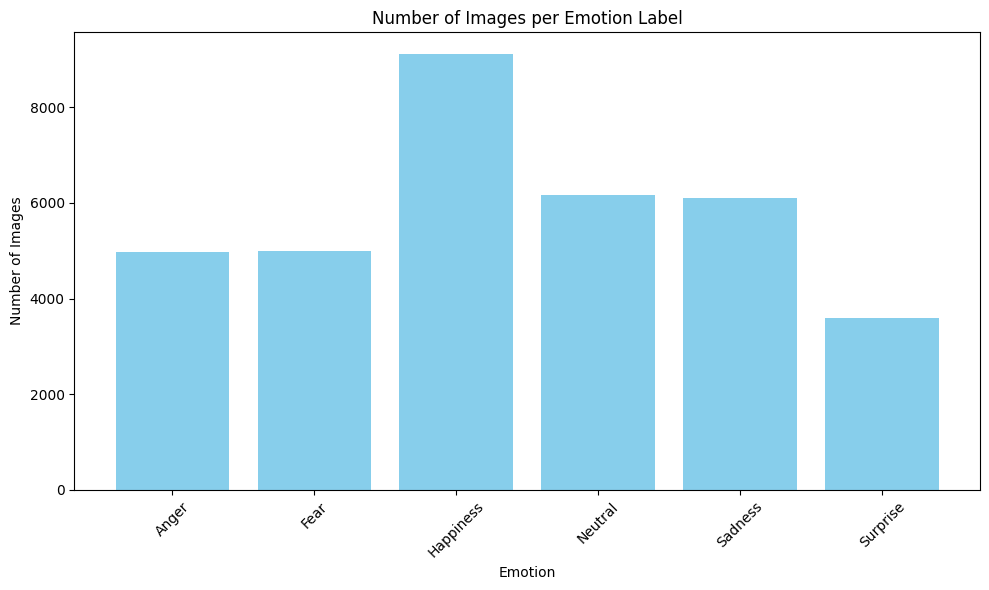

In [24]:
# Specify the input dataset file
dataset_file = 'images_labels_no_duplicates_no_dis_cont.pkl'

# Execute the verification function
plot_items_in_classes(dataset_file)

We could use the new function to randomly reduce the number of items in the Happiness class so it equals the Neutral class, then we can augment all classes to reach a cerain number of images.

## Data preprocessing, splitting, and augmentation

#### Random data reduction to reduce class imbalances

Even if random data reduction on majority classes would make classes much more balanced, we tested the smaller dataset, and the model underfits the data. There is why we are going to train with a bigger dataset for the moment, even if classes are less balanced.

In [ ]:
input_pickle_file = "images_labels_no_duplicates_no_dis_cont.pkl"
output_pickle_file = "reduced_images_3.pkl"
#max_samples_per_class = 5003
max_samples_per_class = 9111

#Reduce majority classes
reduce_majority_classes(input_pickle_file, output_pickle_file, max_samples_per_class)

#### Process and transform the data

In [ ]:
input_pickle_file = "reduced_images_3.pkl"
output_pickle_file = "processed_images_3.pkl"

load_and_preprocess_images(input_pickle_file, output_pickle_file)

#### Encode labels

In [ ]:
#input_pickle_file = "reduced_images_3.pkl"
input_pickle_file = 'processed_images_3.pkl'
output_pickle_file = 'encoded_images.pkl'
label_mapping = 'label_mapping.pkl'
encode_labels(input_pickle_file, output_pickle_file, label_mapping)


#### Split the data

First of all we want to map the each label (string) into a corrresponding integer in a dictionary. Then we want to combine images and corresponding labels in separate lists and convert them into numpy arrays.

We want to sort the labels with a specific order (e.g., alphabetically), so each time we run the cell, we get the set of labels in the same order.

In [ ]:
input_pickle_file = "encoded_images.pkl"
train_output_file = 'train_data_3.pkl'
val_output_file = 'val_data_3.pkl'
test_output_file = 'test_data_3.pkl'

torch.manual_seed(42)

#Split data into train, validation, and test sets
split_data(input_pickle_file, train_output_file, val_output_file, test_output_file)

#### Convert sets into PIL files

In [ ]:
training_set_pickle = 'train_data_3.pkl'
val_set_pickle= 'val_data_3.pkl'
test_set_pickle = 'test_data_3.pkl'

convert_to_pil(training_set_pickle, val_set_pickle, test_set_pickle)

#### Augment the training data

We are going to apply a 60-degree random rotation, in contrast to the 10-degree random rotation we applied in the previous notebook. This is because humans generally, when bending their neck on the side, they do so by 40 to 80 degrees. Therefore, 60 degrees looks like a good compromise.

In [ ]:
input_pickle_file = 'pil_train_data.pkl'
output_pickle_file = 'pil_train_data_augmented_3.pkl'
#target_number_of_images = 8000
target_number_of_images = 10000

#Augment training data
balance_dataset(input_pickle_file, output_pickle_file, target_number_of_images)

#### Convert back to numpy arrays

In [ ]:
pil_augmented_train_data = 'pil_train_data_augmented_3.pkl'
pil_val_data = 'pil_val_data.pkl'
pil_test_data = 'pil_test_data.pkl'

convert_to_numpy_array(pil_augmented_train_data, pil_val_data, pil_test_data)

#### Verify the dataset and labels

In [ ]:
# Load the data from the pickle file
dataset_file = 'numpy_train_data.pkl'

verify_images(dataset_file)

In [ ]:
# Load the data from the pickle file
dataset_file = 'numpy_val_data.pkl'

verify_images(dataset_file)

In [ ]:
# Load the data from the pickle file
dataset_file = 'numpy_test_data.pkl'

verify_images(dataset_file)

It looks like the data has been uploaded correctly.

## Load the data and define the dataloaders

As a final step we want to create dataloaders, which are utilities responsible of loading the data into the model in batches. We have also saved each dataset into a pickle file, so we can easily load them without having to run the code above each time we open this notebook.

In [95]:
# Load the data from a pickle file
#train_dataset = pd.read_pickle('train_data_augmented_3.pkl')
train_dataset = pd.read_pickle('numpy_train_data.pkl')
#train_dataset_original = pd.read_pickle('train_data_3.pkl')
val_dataset = pd.read_pickle('numpy_val_data.pkl')
test_dataset = pd.read_pickle('numpy_test_data.pkl')
label_mapping = pd.read_pickle('label_mapping.pkl')

In [ ]:
# Inspect the structure of the datasets
print("Train Dataset Type:", type(train_dataset))
print("Train Dataset Sample:", train_dataset[:2])  # Print first 2 items for inspection

print("Validation Dataset Type:", type(val_dataset))
print("Validation Dataset Sample:", val_dataset[:2])  # Print first 2 items for inspection

print("Test Dataset Type:", type(test_dataset))
print("Test Dataset Sample:", test_dataset[:2])  # Print first 2 items for inspection

In [97]:
# Convert the datasets to TensorDatasets
train_tensors = convert_to_tensors(train_dataset[0], train_dataset[1])
val_tensors = convert_to_tensors(val_dataset[0], val_dataset[1])
test_tensors = convert_to_tensors(test_dataset[0], test_dataset[1])

# Save the converted datasets to new pickle files
#save_dataset_to_pickle(train_tensors, 'train_data_augmented_3_tensors.pkl')
save_dataset_to_pickle(train_tensors, 'train_data_3_tensors.pkl')
save_dataset_to_pickle(val_tensors, 'val_data_3_tensors.pkl')
save_dataset_to_pickle(test_tensors, 'test_data_3_tensors.pkl')

In [10]:
# Load the datasets for our models
#train_tensors = pd.read_pickle('train_data_augmented_3_tensors.pkl')
train_tensors = pd.read_pickle('train_data_3_tensors.pkl')
val_tensors = pd.read_pickle('val_data_3_tensors.pkl')
test_tensors = pd.read_pickle('test_data_3_tensors.pkl')

In [11]:
# Create DataLoaders for each set
train_loader = DataLoader(train_tensors, batch_size=32, shuffle=True)
val_loader = DataLoader(val_tensors, batch_size=32, shuffle=False)
test_loader = DataLoader(test_tensors, batch_size=32, shuffle=False)